In [153]:
import numpy as np
import glob
import re
import shutil
import random
import itertools
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [154]:
!unzip /content/FINAL_DATASET.zip

Archive:  /content/FINAL_DATASET.zip
   creating: Dataset/SETA/
  inflating: Dataset/SETA/healthy_open1.csv  
  inflating: Dataset/SETA/healthy_open10.csv  
  inflating: Dataset/SETA/healthy_open11.csv  
  inflating: Dataset/SETA/healthy_open12.csv  
  inflating: Dataset/SETA/healthy_open2.csv  
  inflating: Dataset/SETA/healthy_open3.csv  
  inflating: Dataset/SETA/healthy_open4.csv  
  inflating: Dataset/SETA/healthy_open5.csv  
  inflating: Dataset/SETA/healthy_open6.csv  
  inflating: Dataset/SETA/healthy_open7.csv  
  inflating: Dataset/SETA/healthy_open8.csv  
  inflating: Dataset/SETA/healthy_open9.csv  
   creating: Dataset/SETB/
  inflating: Dataset/SETB/healthy_closed1.csv  
  inflating: Dataset/SETB/healthy_closed10.csv  
  inflating: Dataset/SETB/healthy_closed11.csv  
  inflating: Dataset/SETB/healthy_closed12.csv  
  inflating: Dataset/SETB/healthy_closed2.csv  
  inflating: Dataset/SETB/healthy_closed3.csv  
  inflating: Dataset/SETB/healthy_closed4.csv  
  inflating: Da

In [155]:
files = glob.glob("/content/Dataset/*/*")
files

['/content/Dataset/SETA/healthy_open8.csv',
 '/content/Dataset/SETA/healthy_open2.csv',
 '/content/Dataset/SETA/healthy_open1.csv',
 '/content/Dataset/SETA/healthy_open5.csv',
 '/content/Dataset/SETA/healthy_open9.csv',
 '/content/Dataset/SETA/healthy_open3.csv',
 '/content/Dataset/SETA/healthy_open12.csv',
 '/content/Dataset/SETA/healthy_open10.csv',
 '/content/Dataset/SETA/healthy_open7.csv',
 '/content/Dataset/SETA/healthy_open6.csv',
 '/content/Dataset/SETA/healthy_open11.csv',
 '/content/Dataset/SETA/healthy_open4.csv',
 '/content/Dataset/SETC/alzeimer_open12.csv',
 '/content/Dataset/SETC/alzeimer_open9.csv',
 '/content/Dataset/SETC/alzeimer_open2.csv',
 '/content/Dataset/SETC/alzeimer_open8.csv',
 '/content/Dataset/SETC/alzeimer_open5.csv',
 '/content/Dataset/SETC/alzeimer_open6.csv',
 '/content/Dataset/SETC/alzeimer_open7.csv',
 '/content/Dataset/SETC/alzeimer_open3.csv',
 '/content/Dataset/SETC/alzeimer_open1.csv',
 '/content/Dataset/SETC/alzeimer_open10.csv',
 '/content/Datase

In [156]:
def clean(path):
    df = pd.read_csv(path)
    
    for column in df.columns:
        if df[column].dtype == 'object':
            print("Sample : ",path," feature : ",column," is uncleaned")
            df[column] = pd.to_numeric(df[column], errors='coerce')
            df[column] = df[column].fillna(method='ffill')
            df[column] = df[column].fillna(method='bfill')
    df = df.iloc[:1024,:]

    while df.isnull().sum().values.sum() != 0:
        print("Sample : ",path,"getting cleaned")
        df = df.fillna(method = 'ffill')
        df = df.fillna(method = 'bfill')
    df.to_csv(path, index=False)
     
for i in files:
    clean(i)

Sample :  /content/Dataset/SETA/healthy_open2.csv  feature :  16  is uncleaned
Sample :  /content/Dataset/SETA/healthy_open11.csv  feature :  14  is uncleaned
Sample :  /content/Dataset/SETC/alzeimer_open8.csv  feature :  0  is uncleaned
Sample :  /content/Dataset/SETC/alzeimer_open8.csv getting cleaned
Sample :  /content/Dataset/SETC/alzeimer_open5.csv  feature :  0  is uncleaned
Sample :  /content/Dataset/SETC/alzeimer_open5.csv getting cleaned
Sample :  /content/Dataset/SETC/alzeimer_open6.csv  feature :  0  is uncleaned
Sample :  /content/Dataset/SETC/alzeimer_open6.csv getting cleaned
Sample :  /content/Dataset/SETC/alzeimer_open10.csv  feature :  0  is uncleaned
Sample :  /content/Dataset/SETC/alzeimer_open10.csv getting cleaned
Sample :  /content/Dataset/SETD/alzeimer_closed12.csv  feature :  18  is uncleaned
Sample :  /content/Dataset/SETB/healthy_closed6.csv  feature :  14  is uncleaned
Sample :  /content/Dataset/SETB/healthy_closed2.csv  feature :  16  is uncleaned


In [157]:
len(files)

48

In [203]:
train = []
test = []
val = []
pairs = list(itertools.combinations(files,2))

In [204]:
len(pairs)

1128

In [205]:
def to_numeric(csv):
    data = pd.read_csv(csv).values
    return data

In [206]:
def assemble_pairs(pair):
    for i in range(len(pair)):
        sample = list(pair[i])
        x1 = sample[0]
        x2 = sample[1]
        if "closed" in x1:
            sample.append(0)
        elif "open" in x1:
            sample.append(1) 
        if "closed" in x2:
            sample.append(0)
        elif "open" in x2:
            sample.append(1)    
        
        if ("healthy" in x1 and "healthy" in x2) or ("alzeimer" in x1 and "alzeimer" in x2):
            sample.append(0)
        else:
            sample.append(1)    

        sample[0] = to_numeric(x1)
        sample[1] = to_numeric(x2)

        pair[i] = sample   
    return pair      
     

In [207]:
pairs = assemble_pairs(pairs)

In [208]:
len(pairs)

1128

In [209]:
random.shuffle(pairs)

In [210]:
train = pairs[:700]
test = pairs[700:850]
val = pairs[850:]

In [211]:
len(train),len(val),len(test)

(700, 278, 150)

In [167]:
def serialize(wave1,wave2,state,diff):
    feature = {
        'wave1':tf.train.Feature(bytes_list = tf.train.BytesList(value = [wave1.numpy()])),
        'wave2':tf.train.Feature(bytes_list = tf.train.BytesList(value = [wave2.numpy()])),
        'state':tf.train.Feature(bytes_list = tf.train.BytesList(value = [state.numpy()])),
        'diff':tf.train.Feature(bytes_list = tf.train.BytesList(value = [diff.numpy()]))
    }
    example = tf.train.Example(features = tf.train.Features(feature = feature))
    return example.SerializeToString()

In [168]:
def store_records(pairs,name):
    with tf.io.TFRecordWriter("/content/"+name,options=tf.io.TFRecordOptions(compression_type="GZIP")) as writer:
        for sample in pairs:
            x1 = tf.io.serialize_tensor(sample[0].astype(np.float32))
            x2 = tf.io.serialize_tensor(sample[1].astype(np.float32))
            state = tf.io.serialize_tensor(np.array([sample[2],sample[3]]).astype(np.float32))
            output = tf.io.serialize_tensor(np.array([sample[4]]).astype(np.float32))
            serialized = serialize(x1,x2,state,output)
            writer.write(serialized)

store_records(train,"train_rec")
store_records(test,"test_rec")
store_records(val,"val_rec")

In [169]:
def parser(example):
    feature = {
        'wave1':tf.io.FixedLenFeature([],tf.string),
        'wave2':tf.io.FixedLenFeature([],tf.string),
        'state':tf.io.FixedLenFeature([],tf.string),
        'diff':tf.io.FixedLenFeature([],tf.string),
    }
    feature = tf.io.parse_single_example(example,feature)

    wave1 = tf.io.parse_tensor(feature['wave1'],out_type = tf.float32)
    wave1 = tf.reshape(wave1,(1024,19))

    wave2 = tf.io.parse_tensor(feature['wave2'],out_type = tf.float32)
    wave2 = tf.reshape(wave2,(1024,19))

    state = tf.io.parse_tensor(feature['state'],out_type = tf.float32)
    state = tf.reshape(state,(2,))

    diff = tf.io.parse_tensor(feature['diff'],out_type = tf.float32)
    diff = tf.reshape(diff,(1,))

    
    return {'wave1':wave1,'wave2':wave2,'state':state},{'difference':diff}


In [170]:
batch_size = 8

In [171]:
def get_ds(ds):
    ds = tf.data.TFRecordDataset(ds,compression_type = "GZIP")
    ds = ds.map(parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(buffer_size = 300)
    ds = ds.batch(batch_size,drop_remainder = True)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds

In [172]:
train_ds = get_ds("/content/train_rec")
test_ds = get_ds("/content/test_rec")
val_ds = get_ds("/content/val_rec")

In [173]:
train_ds

<_PrefetchDataset element_spec=({'wave1': TensorSpec(shape=(8, 1024, 19), dtype=tf.float32, name=None), 'wave2': TensorSpec(shape=(8, 1024, 19), dtype=tf.float32, name=None), 'state': TensorSpec(shape=(8, 2), dtype=tf.float32, name=None)}, {'difference': TensorSpec(shape=(8, 1), dtype=tf.float32, name=None)})>

In [174]:
def wave_downsample():
    input = tf.keras.Input(batch_size = batch_size,shape = (1024,19))
    output = tf.keras.layers.LSTM(8,return_sequences = True)(input)
    output = tf.keras.layers.Dense(1)(output)
    output = tf.keras.layers.Flatten()(output)
    output = tf.keras.layers.Dense(10)(output)
    model = tf.keras.Model(inputs = [input],outputs = [output])
    return model

In [175]:
class SQD(tf.keras.layers.Layer):
    def __init__(self):
        super(SQD, self).__init__()

    def call(self, inputs):
        x, y = inputs
        diff = tf.subtract(x, y)
        return tf.square(diff)
    

In [213]:
def get_model():
    wave1 = tf.keras.Input(batch_size = batch_size,shape = (1024,19),name = 'wave1')
    wave2 = tf.keras.Input(batch_size = batch_size,shape = (1024,19),name = 'wave2')
    state = tf.keras.Input(batch_size = batch_size,shape = (2,),name = 'state')
    
    output1 = tf.keras.layers.BatchNormalization()(wave1)
    output2 = tf.keras.layers.BatchNormalization()(wave2)

    down_sampler = wave_downsample()
    output1 = down_sampler(output1)
    output2 = down_sampler(output2)

    output = SQD()([output1,output2])
    output = tf.keras.layers.concatenate([output,state])
    output = tf.keras.layers.Dense(5)(output)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid',name = 'difference',activity_regularizer = tf.keras.regularizers.L2(1e-5) )(output)
    
    model = tf.keras.Model(inputs = [wave1,wave2,state],outputs = [output],name = 'FewShot')
    return model

In [214]:
model = get_model()

In [215]:
model.summary()

Model: "FewShot"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 wave1 (InputLayer)             [(8, 1024, 19)]      0           []                               
                                                                                                  
 wave2 (InputLayer)             [(8, 1024, 19)]      0           []                               
                                                                                                  
 batch_normalization_8 (BatchNo  (8, 1024, 19)       76          ['wave1[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_9 (BatchNo  (8, 1024, 19)       76          ['wave2[0][0]']            

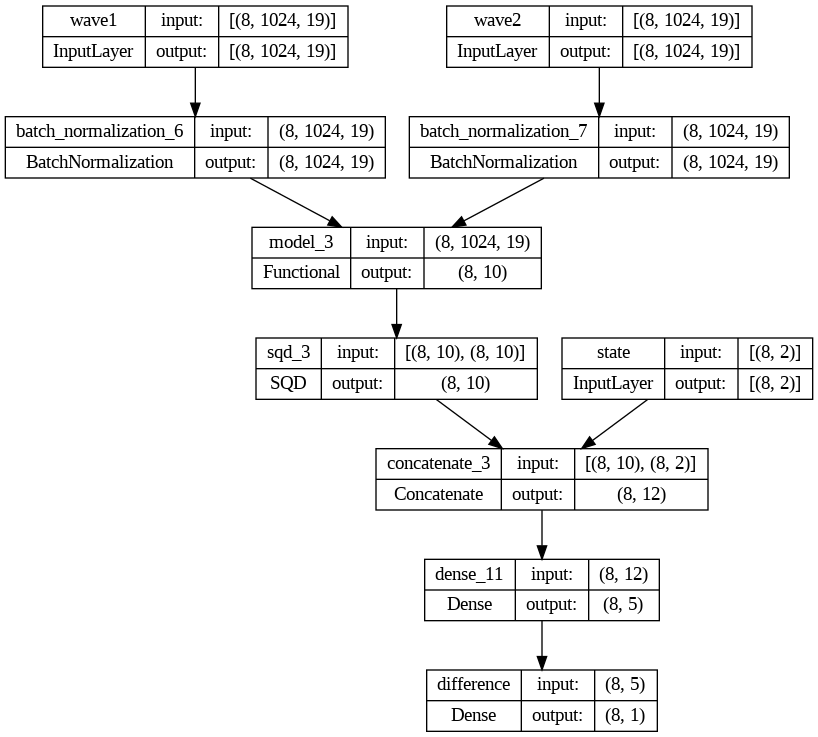

In [179]:
tf.keras.utils.plot_model(model,show_shapes = True,show_layer_names = True)

In [216]:
model.compile(optimizer = tf.keras.optimizers.Adam(clipvalue=0.5),loss = 'binary_crossentropy',metrics = 'accuracy')

In [217]:
model.fit(train_ds,epochs = 5,validation_data = val_ds)

Epoch 1/5
87/87 [==============================] - 12s 66ms/step - loss: 0.9907 - accuracy: 0.5029 - val_loss: 0.6277 - val_accuracy: 0.5919
Epoch 2/5
87/87 [==============================] - 8s 88ms/step - loss: 0.3631 - accuracy: 0.8348 - val_loss: 0.0964 - val_accuracy: 0.9926
Epoch 3/5
87/87 [==============================] - 7s 72ms/step - loss: 0.0498 - accuracy: 0.9957 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 4/5
87/87 [==============================] - 7s 83ms/step - loss: 0.0530 - accuracy: 0.9828 - val_loss: 0.0247 - val_accuracy: 0.9926
Epoch 5/5
87/87 [==============================] - 5s 60ms/step - loss: 0.0330 - accuracy: 0.9914 - val_loss: 0.0139 - val_accuracy: 0.9963


In [218]:
model.evaluate(test_ds)

18/18 [==============================] - 1s 27ms/step - loss: 0.0361 - accuracy: 0.9861


[0.03609884902834892, 0.9861111044883728]